# Майнор "Прикладные задачи анализа данных"
## Домашнее задание 2 [10 баллов] до 23:59 22.03.2018. Предсказание цены акции по экономическим новостям


В этом домашнем задании вы попытаетесь предсказать рост цены акции компании Газпром по новостям о компании. Домашнее задание состоит из трех частей:
1. Предварительная обработка текстов и эксплоративный анализ
2. Baseline алгоритм
3. Творческая часть

Все три части можно считать независимыми – вы можете сделать одну или две из них, однако мы настоятельно советуем выполнить все три. Все инструкции по выполнению домашнего задания – ниже. 



Входные данные:
* Новости о компании "Газпром", начиная с 2010 года
* Стоимость акций компании "Газпром" на ММВБ, начиная с 2010 года
    * цена открытия (Open)
    * цена закрытия (ClosingPrice)
    * максимальная цена за день (DailyHigh)
    * минимальная цена за день (DailyLow) 
    * объем бумаг (VolumePcs)


In [1]:
import pandas as pd
import re
import string
import scipy.stats as sts
import matplotlib.pyplot as plt
%pylab inline

from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import RussianStemmer
from nltk.corpus import stopwords

Populating the interactive namespace from numpy and matplotlib


In [2]:
df_orig = pd.read_csv('texts.csv', encoding='utf_8')
df = df_orig.copy()
df.head()

,date,text
0,09.11.2017,Компания рассчитывает на решение по газовому с...
1,08.11.2017,"Как и предполагал “Ъ”, «Газпром», воспользова..."
2,01.11.2017,Новая редакция американских санкций ставит по...
3,30.10.2017,"Как стало известно “Ъ”, известный на рынке ри..."
4,23.10.2017,"НОВАТЭК, который через пять лет собирается за..."


In [3]:
pr_all = pd.read_csv('gazprom_prices.csv', sep=';', encoding='utf_8')
pr_all.head()

,Date,Open,ClosingPrice,DailyHigh,DailyLow,VolumePcs
0,08.12.2017,"133,43000","132,60000","133,90000","132,00000",16037970
1,07.12.2017,"133,70000","133,02000","133,87000","132,81000",18198430
2,06.12.2017,"133,33000","134,00000","134,29000","132,91000",14641730
3,05.12.2017,"133,48000","133,65000","133,99000","132,78000",12684800
4,04.12.2017,"133,01000","133,77000","134,00000","131,93000",17818980


## Часть 1. Вводная [3 балла]

Проведите предобработку текстов: если считаете нужным, выполните токенизацию, приведение к нижнему регистру, лемматизацию и/или стемминг. Ответьте на следующие вопросы:
* Есть ли корреляция между средней длинной текста за день и ценой закрытия?
* Есть ли корреляция между количеством упоминаний Алексея Миллера  и ценой закрытия? Учтите разные варианты написания имени.
* Упоминаний какого газопровода в статьях больше: 
    * "северный поток"
    * "турецкий поток"?
* Кого упоминают чаще:
    * Алексея Миллера
    * Владимира Путина?
* О каких санкциях пишут в статьях?

Проведём предобработку данных.

In [4]:
idx = df['text'].str.contains('^\s*$', flags=re.IGNORECASE, regex=True, na=False)

In [5]:
idx.tail()

1198    False
1199    False
1200    False
1201    False
1202     True
Name: text, dtype: bool

Видим, что некоторые новости вовсе пустые. Избавимся от них!

In [6]:
df = df[~idx]

In [7]:
df.head()

,date,text
0,09.11.2017,Компания рассчитывает на решение по газовому с...
1,08.11.2017,"Как и предполагал “Ъ”, «Газпром», воспользова..."
2,01.11.2017,Новая редакция американских санкций ставит по...
3,30.10.2017,"Как стало известно “Ъ”, известный на рынке ри..."
4,23.10.2017,"НОВАТЭК, который через пять лет собирается за..."


`CountVectorizer` не берёт слова длинной 1 (например Ъ), а так же считает, что все слова в нижнем регистре.

In [8]:
for i in (CountVectorizer().build_tokenizer()(df['text'].values[1])):
    print(i)

Как
предполагал
Газпром
воспользовавшись
жалобами
иностранных
партнеров
на
налогообложение
добычных
проектов
РФ
смог
добиться
снижения
налога
на
добычу
полезных
ископаемых
НДПИ
для
своих
ачимовских
залежей
почти
до
уровня
независимых
производителей
газа
Эта
льгота
распространится
не
только
на
СП
Газпрома
OMV
Wintershall
но
на
структуры
монополии
разрабатывающие
месторождения
запасами
от
трлн
кубометров
газа
По
расчетам
это
приведет
тому
что
2018
году
платеж
по
НДПИ
для
Газпрома
его
ачимовских
СП
снизится
на
млрд
руб
из
которых
млрд
руб
сэкономит
сама
монополия


In [9]:
for i in word_tokenize(df['text'].values[1]):
    print(i)

Как
и
предполагал
“
Ъ
”
,
«
Газпром
»
,
воспользовавшись
жалобами
иностранных
партнеров
на
налогообложение
добычных
проектов
в
РФ
,
смог
добиться
снижения
налога
на
добычу
полезных
ископаемых
(
НДПИ
)
для
своих
ачимовских
залежей
почти
до
уровня
независимых
производителей
газа
.
Эта
льгота
распространится
не
только
на
СП
«
Газпрома
»
с
OMV
и
Wintershall
,
но
и
на
структуры
монополии
,
разрабатывающие
месторождения
с
запасами
от
1
трлн
кубометров
газа
.
По
расчетам
“
Ъ
”
,
это
приведет
к
тому
,
что
в
2018
году
платеж
по
НДПИ
для
«
Газпрома
»
и
его
ачимовских
СП
снизится
на
2,8
млрд
руб.
,
из
которых
2,2
млрд
руб
.
сэкономит
сама
монополия
.


Очевидно, что `CountVectorizer` подходит больше, чем `word_tokenize` из `nltk`. Будем использовать его.

Проведём стемминг. Благодяря нему, например, слова "вагонам", "вагоне", "вагоны", "вагону" будут считаться за одно. Поскольку стемминг уменьшает количество уникальных слов в словаре, это так же увеличивает скорость вычислений. Модуль `nltk.stem` предлагает несколько стеммеров, воспользуемся одним из самых популярных -- `Snowball`.

In [10]:
stemmer = RussianStemmer()
words = [u'вагонам', u'вагоне', u'вагоны', u'вагону']
for i in [stemmer.stem(w) for w in words]:
    print(i)

вагон
вагон
вагон
вагон


In [11]:
print (stemmer.stem(u'вагон'))

вагон


Теперь объеденим всё в один метод.

In [12]:
df_bak = df.copy()

In [13]:
def text_process(mess):
    '''
    1. Удаляет пунктуацию
    2. Удаляет стоп-слова
    3. Приводит к нижнему регистру
    4. Токенизирует
    5. Проводит стемминг
    6. Возвращает лист чистого текста
    '''
    
    nopunc = [char for char in mess if char not in string.punctuation]
    nopunc = ''.join(nopunc).lower()
    words = CountVectorizer().build_tokenizer()(nopunc)
    stemmer = RussianStemmer()
    stemmed = [stemmer.stem(w) for w in words]
    res = [word for word in stemmed if word not in stopwords.words('russian')]
    return ' '.join(res)

In [14]:
clean_text = df['text'].apply(text_process)

In [15]:
df['text'] = clean_text

In [16]:
df.head()

,date,text
0,09.11.2017,компан рассчитыва решен газов спор украин конц...
1,08.11.2017,предполага газпр воспользова жалоб иностра пар...
2,01.11.2017,нов редакц американск санкц став угроз зарубеж...
3,30.10.2017,стал известн известн рынк рискменеджер итспеци...
4,23.10.2017,новатэк котор пят лет собира запуст камчатк кр...


In [17]:
l = []
for i in df['text'].values:
    l.append(len(i))

In [18]:
df['length'] = pd.Series(l)

In [19]:
d = []
for date in pr_all['Date'].values:
    curr_len = df.loc[df['date'] == date, 'length']
    if curr_len.shape != (0,):
        d.append({'date': date,
                  'length': curr_len.values[0],
                  'price': pr_all.loc[pr_all['Date'] == date, 'ClosingPrice'].values[0]})

compare_df = pd.DataFrame(d)
compare_df['length'] = compare_df['length'].astype(float)
compare_df['price'] = compare_df['price'].str.replace(',', '.').astype(float)

In [20]:
# Нормализуем величины.
# compare_df['length'] = (compare_df['length'] - np.mean(compare_df['length'])) / np.std(compare_df['length'])
# compare_df['price'] = (compare_df['price'] - np.mean(compare_df['price'])) / np.std(compare_df['price'])
# compare_df.head()

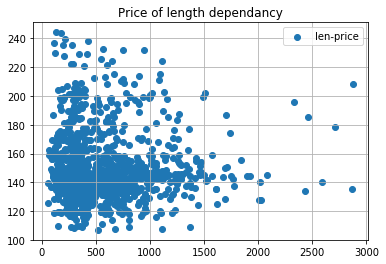

In [21]:
plt.scatter(compare_df['length'], compare_df['price'], label='len-price')
plt.legend()
plt.title(r'Price of length dependancy')
plt.grid(1)
plt.show()

In [22]:
r = sts.pearsonr(compare_df['length'], compare_df['price'])[0]
r

0.016147036755291833

In [23]:
rho = sts.spearmanr(compare_df['length'], compare_df['price'])[0]
rho

-0.003923616826558613

Корреляции между длиной новости и ценой закрытия нет никакой.

In [24]:
# Стеммер иногда делает "алекс", а иногда "алексе". Но "миллер" всегда одинаков.
#
words = [u'алексей', u'алексею', u'алексеем', u'алексея', u'миллеру', u'миллера', u'миллером']
for w in words:
    print(stemmer.stem(w))

алекс
алекс
алексе
алексе
миллер
миллер
миллер


In [25]:
compare_df['miller'] = df['text'].str.contains(u'алекс миллер|алексе миллер', regex=True, na=False)

In [26]:
compare_df['miller'] = compare_df['miller'].astype(int)
compare_df.loc[compare_df['miller'] == 1, 'miller'].count()

99

Насколько зависит цена закрытия акции от количества упоминаний Алексея Миллера в новостях за этот день?

Посмотрим сначала на коэффициент ранговой корреляции, а потом проверим гипотезу о том, что средние по второй величине различаются при 1 и 0 в бинарной величине, для того чтобы подтвердить статистическую значимость ранговой корреляции.

In [27]:
rho = sts.spearmanr(compare_df['miller'], compare_df['price'])[0]
rho

0.07366900658183365

7% на большой выборке - не такая уж и маленькая величина.

Посчитаем среднее для цен закрытия в дни без упоминания А. Миллера.

In [28]:
mu = compare_df.loc[compare_df['miller'] == 0, 'price'].mean()
x_bar = compare_df.loc[compare_df['miller'] == 1, 'price'].mean()
std = compare_df.loc[compare_df['miller'] == 0, 'price'].std()
n = x_bar = compare_df.loc[compare_df['miller'] == 1, 'price'].count()

print('Среднее по выборке при 0: {0:.3f}\nСреднее по выборке при 1: {1:.3f}\n\
Стандатрное отклонение на выборке: {2:.3f}\nВыборка размера {3}'.format(mu, x_bar, std, n))

Среднее по выборке при 0: 149.446
Среднее по выборке при 1: 99.000
Стандатрное отклонение на выборке: 23.370
Выборка размера 99


При тестировании гипотезы будем предполагать нормальность распределения величин.

$H_0$: $\mu = 149.446$

$H_1$: $\mu \neq 149.446$ (упоминание А. Миллера влияет на цену)

$\alpha = 0.05$

$\bar{x} = 154.259$

$\sigma = 23.37$


In [29]:
t = (154.259 - 149.446) / (23.37 / sqrt(99))
t

2.049154700382606

Это двухсторонний тест с уровнем значимости $0.5$. Сравниваем с положительным критическим значением $1.96$.

In [30]:
t > 1.96

True

Вычисленная $t$ статистика попала в Rejection Region. Значит $H_0$ отвергается и упоминания А.Миллера _действительно_ влияют на цену закрытия.

Количество упоминаний 'северный поток' и 'турецкий поток'

In [28]:
df['text'].str.contains(u'северн\s*поток', regex=True, na=False).sum()

12

In [29]:
df['text'].str.contains(u'турецк\s*поток', regex=True, na=False).sum()

34

Количество упоминаний 'владимир путин' и 'алексей миллер'

In [30]:
df['text'].str.contains(u'владимир\s*путин', regex=True, na=False).sum()

59

In [31]:
df['text'].str.contains(u'алекс\s*миллер|алексе\s*миллер', regex=True, na=False).sum()

102

О каких санкциях пишут в статьях?

In [32]:
df[df['text'].str.contains(u'санкц', regex=True, na=False)]

,date,text,length
2,01.11.2017,нов редакц американск санкц став угроз зарубеж...,593
7,05.10.2017,газпр нефт пробур перв скважин аяшск участк ше...,695
34,10.07.2017,газпр нефт стат основн партнер испанск repsol ...,683
49,07.06.2017,газпр перв развернут комментар решен стокгольм...,1107
76,29.03.2017,газпр нефт планир инвестирова 2017 млрд руб се...,808
84,07.03.2017,крупн российск банк сбербанк газпромбанк объяв...,567
90,16.02.2017,газпр заяв начал коммерческ переговор китайск ...,321
120,16.12.2016,предправлен газпром алекс миллер назва решен к...,192
148,07.10.2016,стал известн нов проект газпром сжижен газ бал...,447
206,20.05.2016,скор выйдет 100ну закупк трубн продукц росс за...,1147


## Часть 2. Классификационная [3 балла]
Вам предстоит решить следующую задачу: по текстам новостей за день определить, вырастет или понизится цена закрытия.
Для этого:
* бинаризуйте признак "цена закрытия":  новый признак ClosingPrice_bin равен 1, если по сравнению со вчера цена не упала, и 0 – в обратном случаея;
* составьте бучающее и тестовое множество: данные до начала 2016 года используются для обучения, данные с 2016 года и позже – для тестирования.

Таким образом, в каждлый момент времени мы знаем: 
* ClosingPrice_bin – бинарый целевой признак
* слова из статей, опубликованных в этот день – объясняющие признаки

В этой части задания вам нужно сделать baseline алгоритм и попытаться его улучшить в следующей части. 

Используйте любой известный вам алгоритм классификации текстов для того, Используйте $tf-idf$ преобразование, сингулярное разложение, нормировку признакого пространства и любые другие техники обработки данных, которые вы считаете нужным. Используйте accuracy и F-measure для оценки качества классификации. Покажите, как  $tf-idf$ преобразование или сингулярное разложение или любая другая использованная вами техника влияет на качество классификации.
Если у выбранного вами алгоритма есть гиперпараметры (например, $\alpha$ в преобразовании Лапласа для метода наивного Байеса), покажите, как изменение гиперпараметра влияет на качество классификации.

In [4]:
df_texts = pd.read_csv('texts.csv', parse_dates=True, index_col='date')
df_texts.head(3)

,text
date,
2017-09-11,Компания рассчитывает на решение по газовому с...
2017-08-11,"Как и предполагал “Ъ”, «Газпром», воспользова..."
2017-01-11,Новая редакция американских санкций ставит по...


In [5]:
df_prices = pd.read_csv('gazprom_prices.csv', parse_dates=True, sep=';', index_col='Date')
df_prices.head(3)

,Open,ClosingPrice,DailyHigh,DailyLow,VolumePcs
Date,,,,,
2017-08-12,"133,43000","132,60000","133,90000","132,00000",16037970
2017-07-12,"133,70000","133,02000","133,87000","132,81000",18198430
2017-06-12,"133,33000","134,00000","134,29000","132,91000",14641730


In [6]:
df = df_texts.join(df_prices)[['text', 'ClosingPrice']]
df.head(3)

,text,ClosingPrice
date,,
2017-09-11,Компания рассчитывает на решение по газовому с...,"131,50000"
2017-08-11,"Как и предполагал “Ъ”, «Газпром», воспользова...","132,30000"
2017-01-11,Новая редакция американских санкций ставит по...,"126,50000"


In [7]:
df.columns = ['text', 'price']

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1203 entries, 2017-09-11 to 2010-04-01
Data columns (total 2 columns):
text     1203 non-null object
price    1159 non-null object
dtypes: object(2)
memory usage: 68.2+ KB


In [9]:
df = df.dropna()

In [10]:
df.price = df.price.apply(lambda x: x.replace(',', '.')).astype(np.float)

In [11]:
df['price_change'] = df.price - df.price.shift(1)

In [12]:
df['class_label'] = (df.price_change >= 0) + 0

In [13]:
df.text = df.text.apply(text_process)

NameError: name 'text_process' is not defined

In [14]:
threshold_date = pd.Timestamp('2015-12-31 23:59:59')

In [15]:
test_dates = df.index[np.where(df.index >= threshold_date)]
train_dates = df.index[np.where(df.index < threshold_date)]

In [16]:
df_train = df.loc[train_dates]
df_test = df.loc[test_dates]

In [17]:
x_train, y_train = df_train.text.values, df_train.class_label.values
x_test, y_test   = df_test.text.values,  df_test.class_label.values

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [19]:
tf = TfidfVectorizer()

In [20]:
tf.fit(df.text)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [21]:
x_train = tf.transform(x_train)
x_test = tf.transform(x_test)

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score

In [23]:
knn = KNeighborsClassifier()

In [24]:
from time import time

In [25]:
time()

1521744521.899203

In [26]:
def bench(clf, x_tr, y_tr, x_te, y_te):
    start = time()
    clf.fit(x_tr, y_tr)
    mid = time()
    y_tr_pred = clf.predict(x_tr)
    y_te_pred = clf.predict(x_te)
    end = time()
    return accuracy_score(y_tr, y_tr_pred), f1_score(y_tr, y_tr_pred),\
            accuracy_score(y_te, y_te_pred), f1_score(y_te, y_te_pred),\
            mid - start, (end - mid) / 2.0

In [27]:
from sklearn.linear_model import PassiveAggressiveClassifier, RidgeClassifier, SGDClassifier, Perceptron
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.ensemble import RandomForestClassifier

In [28]:
clf_lst = [PassiveAggressiveClassifier, RidgeClassifier, SGDClassifier,\
           Perceptron, LinearSVC, BernoulliNB, MultinomialNB,
          KNeighborsClassifier, NearestCentroid, RandomForestClassifier]

In [55]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import SelectKBest, SelectPercentile

import warnings
warnings.filterwarnings('ignore')

In [51]:
def get_measurements_df(x_tr, y_tr, x_te, y_te, result_type=2):
    reses = []
    for clf in clf_lst:
        clf_name = str(clf).split('.')[-1]
        clf_name = clf_name.split("'")[0]
        try:
            res = [clf_name] + list(bench(clf(), x_tr, y_tr, x_te, y_te))
            reses.append(res)
        except:
            pass
    pre_res = pd.DataFrame(reses, columns=['name', 'train_acc', 'train_f1', 'test_acc', 
                                              'test_f1', 'train_time', 'test_time'])
    pre_res = pre_res.sort_values(by='test_f1')
    
    if result_type == 0:
        return pre_res[['name', 'test_acc', 'test_f1']]
    
    if result_type == 1:
        return pre_res[['name', 'train_acc', 'train_f1', 'test_acc', 'test_f1']]
    
    if result_type != 2:
        raise ValueError("Unknown result_type")
    
    return pre_res

In [52]:
# PCA does not support sparse input.
svd = TruncatedSVD()

In [53]:
x_train_svd = svd.fit_transform(x_train)
x_test_svd = svd.fit_transform(x_test)

In [57]:
get_measurements_df(x_train_svd, y_train, x_test_svd, y_test, result_type=0)

,name,test_acc,test_f1
0,PassiveAggressiveClassifier,0.441860,0.000000
2,SGDClassifier,0.472868,0.433333
8,RandomForestClassifier,0.468992,0.475096
7,NearestCentroid,0.453488,0.479705
6,KNeighborsClassifier,0.507752,0.554386
4,LinearSVC,0.550388,0.702564
1,RidgeClassifier,0.554264,0.708861
3,Perceptron,0.558140,0.716418
5,BernoulliNB,0.558140,0.716418


In [60]:
best_perc = SelectPercentile()

In [67]:
x_train_perc = best_perc.fit_transform(x_train, y_train)
x_test_perc = best_perc.transform(x_test)

In [70]:
get_measurements_df(x_train_perc, y_train, x_test_perc, y_test, result_type=0)

,name,test_acc,test_f1
7,KNeighborsClassifier,0.430233,0.013423
3,Perceptron,0.441860,0.496503
2,SGDClassifier,0.484496,0.536585
9,RandomForestClassifier,0.500000,0.537634
8,NearestCentroid,0.492248,0.561873
4,LinearSVC,0.484496,0.566775
5,BernoulliNB,0.453488,0.568807
1,RidgeClassifier,0.472868,0.569620
0,PassiveAggressiveClassifier,0.484496,0.575080
6,MultinomialNB,0.511628,0.646067


In [71]:
best_k_best = SelectKBest()
x_train_best = best_k_best.fit_transform(x_train, y_train)
x_test_best = best_k_best.transform(x_test)

In [73]:
get_measurements_df(x_train_best, y_train, x_test_best, y_test, result_type=0)

,name,test_acc,test_f1
3,Perceptron,0.457364,0.156627
8,NearestCentroid,0.465116,0.197674
5,BernoulliNB,0.468992,0.217143
9,RandomForestClassifier,0.468992,0.225989
7,KNeighborsClassifier,0.527132,0.682292
2,SGDClassifier,0.531008,0.682415
1,RidgeClassifier,0.534884,0.687500
4,LinearSVC,0.534884,0.687500
0,PassiveAggressiveClassifier,0.538760,0.692506
6,MultinomialNB,0.550388,0.708543


## Часть 3. Творческая [4 балла]
Придумайте и попытайтесь сделать еще что-нибудь, чтобы улучшить качество классификации. 
Направления развития:
* Морфологический признаки: 
    * использовать в качестве признаков только существительные или только именованные сущности;
* Модели скрытых тем:
    * использовать в качестве признаков скрытые темы;
    * использовать в качестве признаков динамические скрытые темы 
    пример тут: (https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/dtm_example.ipynb)
* Синтаксические признаки:
    * использовать SOV-тройки в качестве признаков
    * кластеризовать SOV-тройки по усредненным эмбеддингам  (обученные word2vec модели можно скачать отсюда: (http://rusvectores.org/ru/models/ или https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md) и использовать только центроиды кластеров в качестве признаков
* что-нибудь еще     

In [31]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

Напишем функции для фильтрации слов в тексте

In [19]:
def filter_text(text, filter):
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc).lower()
    words = CountVectorizer().build_tokenizer()(nopunc)
    nouns = [word for word in words if filter(word)]
    return ' '.join(nouns)

def only_nouns(text):
    def is_noun(word):
        return morph.parse(word)[0].tag.POS == 'NOUN'
    return filter_text(text, is_noun)

Датафрейм только с существительными:

In [20]:
df_nouns = df_orig.copy()
df_nouns.text = df_nouns.text.apply(only_nouns).apply(text_process)
df_nouns.head()

,date,text
0,09.11.2017,компан решен спор украин конц декабр газпр реш...
1,08.11.2017,газпр жалоб партнер налогообложен проект рф сн...
2,01.11.2017,редакц санкц угроз проект компан граждан компа...
3,30.10.2017,рынк рискменеджер итспециалист вад кулик работ...
4,23.10.2017,новатэк лет камчатк термина пробл обеспечен ре...


Так как хороших синтаксических анализаторов для русского языка не было найдено, в качестве демонстрации синтаксических признаков оставим только существительные и глаголы.

In [25]:
def syntactic(text):
    def is_syntactic(word):
        return morph.parse(word)[0].tag.POS in ['NOUN', 'VERB']
    return filter_text(text, is_syntactic)

In [26]:
df_synt = df_orig.copy()
df_synt.text = df_synt.text.apply(syntactic).apply(text_process)
df_synt.head()

,date,text
0,09.11.2017,компан рассчитыва решен спор украин конц декаб...
1,08.11.2017,предполага газпр жалоб партнер налогообложен п...
2,01.11.2017,редакц санкц став угроз проект компан граждан ...
3,30.10.2017,стал рынк рискменеджер итспециалист вад кулик ...
4,23.10.2017,новатэк лет собира камчатк термина пробл обесп...


## Сдача домашнего задания

Дедлайн сдачи домашнего задания:  23:59 22.03.2018. Каждый день просрочки дедлайна штрафуется -1 баллом.

Результаты домашнего задания должны быть оформлены в виде отчета в jupyter notebook.
Нормальный отчёт должен включать в себя:
* Краткую постановку задачи и формулировку задания
* Описание минимума необходимой теории и/или описание используемых инструментов 
* Подробный пошаговый рассказ о проделанной работе
* **Аккуратно** оформленные результаты
* Подробные и внятные ответы на все заданные вопросы 
* Внятные выводы – не стоит относится к домашнему заданию как к последовательности сугубо технических шагов, а стоит относится скорее как к небольшому практическому исследованию, у которого есть своя цель и свое назначение.

Задание выполняется в группе до трех человек. Не забудьте перечислить фамилии всех, кто работал над домашнем задании, в jupyter notebook.  

В случае использования какого-либо строннего источника информации обязательно дайте на него ссылку (поскольку другие тоже могут на него наткнуться). Плагиат наказывается нулём баллов за задание и предвзятым отношением в будущем.


При возникновении проблем с выполнением задания обращайтесь с вопросами к преподавателю по семинарским занятиям в вашей группе или у учебным ассистентам.

Учебный ассистент по ДЗ 2: Таисия Глушкова (email: glushkovato@gmail.com, telegram: @glushkovato).


Небрежное оформление отчета существенно отразится на итоговой оценке. Весь код из отчёта должен быть воспроизводимым, если для этого нужны какие-то дополнительные действия, установленные модули и т.п. — всё это должно быть прописано в отчете в явном виде.

Сдача отчетов осуществляется через систему AnyTask.

